  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


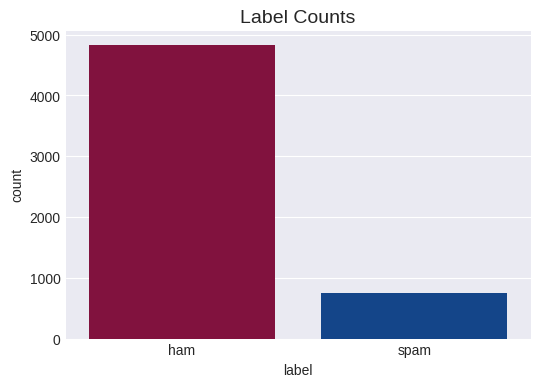

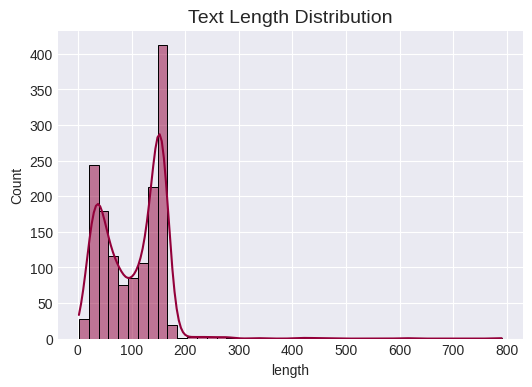

todays voda numbers ending selected receive award match quoting claim code standard rates app
     label                                               text  length
1463   ham  ok good later come lucky told earlier later pp...     114
2313   ham                                               guys      23
3290   ham  smoking people use wylie smokes justify ruinin...      85
2604   ham                  times job today ok umma ask speed      57
4018  spam  ve selected stay british hotels holiday valued...     159


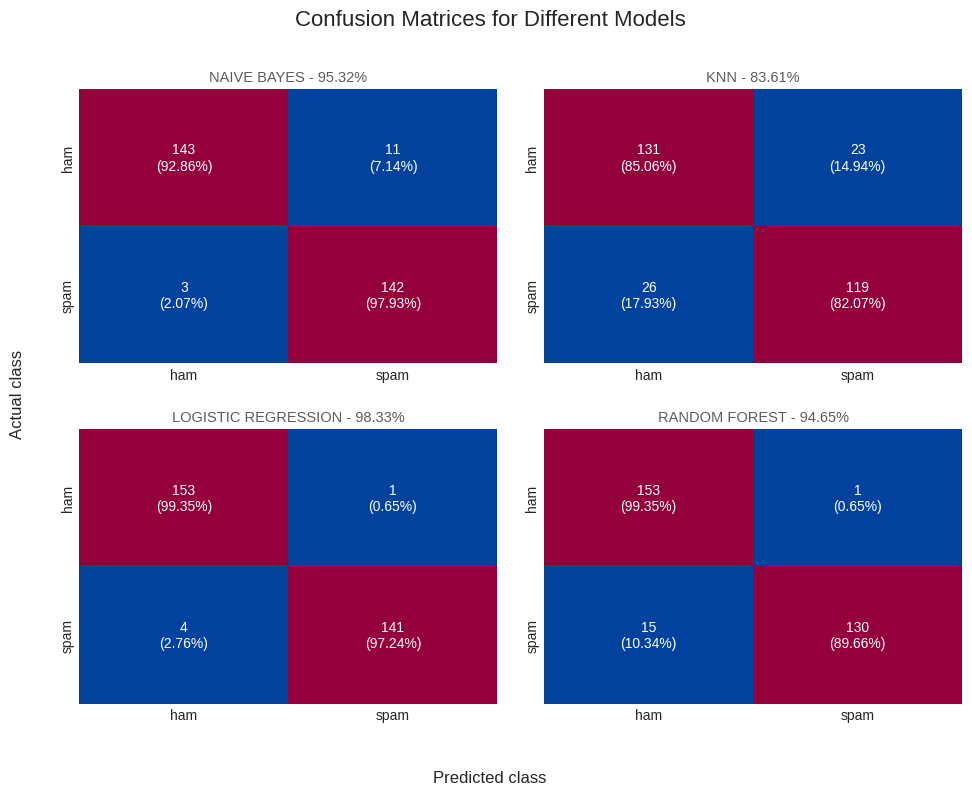

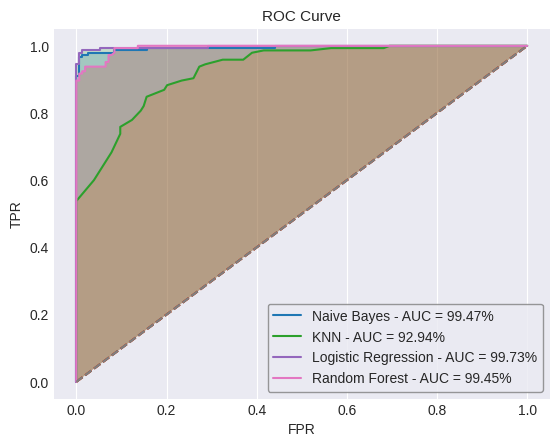

KeyError: "None of [Index(['precision', 'recall', 'fscore'], dtype='object')] are in the [columns]"
              m_o_d_e_l m_e_t_r_i_c     h_a_m   s_p_a_m  \
0                         precision  0.979452  0.928105   
1           NAIVE BAYES      recall  0.928571  0.979310   
2                            fscore  0.953333  0.953020   
4                   KNN      recall  0.850649  0.820690   
7   LOGISTIC REGRESSION      recall  0.993506  0.972414   
10        RANDOM FOREST      recall  0.993506  0.896552   

             u_n_i_q_u_e___i_d  
0                   _precision  
1           NAIVE BAYES_recall  
2                      _fscore  
4                   KNN_recall  
7   LOGISTIC REGRESSION_recall  
10        RANDOM FOREST_recall  


In [ ]:
import re
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
np.random.seed(20)

# Load and prepare the dataset
spam_data = pd.read_csv("spam.csv", encoding='latin-1', usecols=['v1', 'v2'])
spam_data.columns = ["label", "text"]
print(spam_data.head(5))

# Function to plot confusion matrix
def plot_conf_matrix(model, X, y, ax, **kwargs):
    predictions = model.predict(X)
    acc = accuracy_score(y, predictions)
    cm = confusion_matrix(y, predictions)
    cm_norm = cm / cm.sum(1).reshape((-1, 1))
    labels = [f"{v}\n({pct:.2%})" for v, pct in zip(cm.flatten(), cm_norm.flatten())]
    labels = np.array(labels).reshape(cm.shape)

    sns.heatmap(cm, annot=labels, fmt="",
                ax=ax, yticklabels=le.classes_,
                xticklabels=le.classes_, cbar=False,
               cmap=["#00429d", "#93003a"])
    ax.set_title(f"{kwargs.get('name').upper()} - {acc:.2%}", size=10.5, alpha=0.75)

# Function to build model pipeline
def create_model_pipeline(model, name):
    pipeline = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(min_df=2, stop_words=list(ENGLISH_STOP_WORDS))),
        (name, model)
    ])
    return pipeline

# Function to plot ROC curve
def plot_roc_curve(model, X, y, ax, **kwargs):
    pred_prob = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, pred_prob)
    fpr, tpr, threshold = roc_curve(y, pred_prob)

    ax.plot(fpr, tpr, label=f'{kwargs.get("name")} - AUC = {auc:.2%}')
    straight_line = np.linspace(0, 1, len(fpr))
    ax.plot(straight_line, straight_line, linestyle='--')
    ax.fill_between(fpr, fpr, tpr, alpha=0.2)
    ax.legend(loc=4, frameon=True, edgecolor="gray")
    ax.set_title("ROC Curve", size=11)
    ax.grid(visible=False, axis="y")
    ax.set(ylabel="TPR", xlabel="FPR")

# Function to evaluate model
def assess_model(model, X, y, name):
    predictions = model.predict(X)
    prf = precision_recall_fscore_support(y, predictions)[:-1]
    metrics = ["precision", "recall", "fscore"]
    arrays = [["", name, ""], metrics]
    index = pd.MultiIndex.from_arrays(arrays, names=('model', 'metric'))
    df = pd.DataFrame(prf, columns=le.classes_, index=index)

    return df

# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=spam_data, x='label', palette=["#93003a", "#00429d"])
plt.title("Label Counts", fontsize=14)
plt.show()

# Balance the dataset
spam = spam_data[spam_data.label == 'spam']
ham = spam_data[spam_data.label == 'ham'].sample(spam.shape[0])

balanced_data = pd.concat([spam, ham], axis=0)

# Add text length feature
balanced_data['length'] = balanced_data.text.apply(len)

# Plot text length distribution
plt.figure(figsize=(6, 4))
sns.histplot(data=balanced_data, x='length', color='#93003a', kde=True)
plt.title("Text Length Distribution", fontsize=14)
plt.show()

# Text preprocessing function
def clean_text(message):
    text_split = message.lower().split()
    cleaned_text = [word for word in text_split if word not in string.punctuation]
    cleaned_text = [re.sub("[^a-zA-Z]", " ", word).strip() for word in cleaned_text]
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = [word for word in cleaned_text.split() if word not in ENGLISH_STOP_WORDS and len(word) > 1]

    return " ".join(cleaned_text)

# Example text cleaning
print(clean_text("Todays Voda numbers ending 1225 are selected to receive a £50 award. If you have a match please call 08712300220 quoting claim code 3100 standard rates app"))

# Apply text cleaning to the dataset
balanced_data['text'] = balanced_data['text'].apply(clean_text)

print(balanced_data.sample(5))

# Encode labels
le = LabelEncoder()

balanced_data.reset_index(drop=True, inplace=True)
X = balanced_data.text
y = le.fit_transform(balanced_data.label)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train models
model_pipelines = {
    "Naive Bayes": create_model_pipeline(MultinomialNB(), "nb").fit(X_train, y_train),
    "KNN": create_model_pipeline(KNeighborsClassifier(n_neighbors=70), "knn").fit(X_train, y_train),
    "Logistic Regression": create_model_pipeline(LogisticRegression(solver="liblinear"), "lr").fit(X_train, y_train),
    "Random Forest": create_model_pipeline(RandomForestClassifier(max_depth=10), "rfc").fit(X_train, y_train)
}

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, (model_name, model) in zip(axes.ravel(), model_pipelines.items()):
    plot_conf_matrix(model, X_test, y_test, ax, name=model_name)

fig.supxlabel("Predicted class", fontsize=12)
fig.supylabel("Actual class", x=0.02, fontsize=12)
fig.suptitle("Confusion Matrices for Different Models", size=16)
plt.tight_layout(pad=2.0)
fig.patch.set_alpha(0)
plt.show()

# Plot ROC curves
plt.figure()
ax = plt.gca()

for model_name, model in model_pipelines.items():
    plot_roc_curve(model, X_test, y_test, ax, name=model_name)

ax.set_alpha(0)
plt.show()

# Evaluate models and display results
results_df = pd.DataFrame()

for i, (model_name, model) in enumerate(model_pipelines.items()):
    model_results = assess_model(model, X_test, y_test, name=model_name.upper())
    if results_df.empty:
        results_df = model_results
    else:
        results_df = pd.concat((results_df, model_results), axis=0)

import pandas as pd

# Assuming the results_df is already defined and contains the evaluation metrics

# Ensure the index is unique before pivoting
results_df = results_df.reset_index()
results_df['unique_id'] = results_df['model'] + "_" + results_df['metric']

# Drop duplicates if any
results_df = results_df.drop_duplicates(subset='unique_id')

# Pivot using the correct columns
try:
    results_df = results_df.pivot(index='metric', columns='model', values=['precision', 'recall', 'fscore'])
except KeyError as e:
    print(f"KeyError: {e}")

# Flatten multi-level columns
results_df.columns = ['_'.join(col).strip() for col in results_df.columns.values]

# Display the styled DataFrame
results_df = results_df.dropna()
results_df.style.background_gradient(cmap='coolwarm').set_caption("Model Evaluation Metrics").format("{:.2f}")

print(results_df)